## Learning LangGraph 

In [59]:
import langchain
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langchain_google_genai import GoogleGenerativeAIEmbeddings

from langgraph.graph import StateGraph, START, END

from dotenv import load_dotenv
from pprint import pprint
import random
from loguru import logger
from typing import TypedDict, Annotated, List
from IPython.display import Image

In [4]:
gemini_flash_model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [5]:
gpt_oss_20b_model = ChatGroq(
    model="openai/gpt-oss-20b",
    temperature=0,
    max_tokens=None,
    reasoning_format="parsed",
    timeout=None,
    max_retries=2,
)

In [6]:
gemini_flash_model.invoke("what is the capital of india").content

'The capital of India is **New Delhi**.'

In [7]:
gpt_oss_20b_model.invoke("what is the capital of india").content

'The capital of India is **New\u202fDelhi**.'

### First Sequential Workflow - non LLM based

- BMI Calculator

- Inputs: ht, weight

- Output: BMI

In [21]:
# define state

class BMIState(TypedDict):
    weight_kg: float
    height_m: float
    bmi: float
    category: str

In [23]:
# define graph

bmi_graph = StateGraph(BMIState)

# define nodes - nodes are functions that take in a state and return a state

def calculate_bmi(state: BMIState) -> BMIState:
    bmi = state["weight_kg"] / (state["height_m"] ** 2)
    state["bmi"] = round(bmi, 2) # make a partial update to the state
    return state

def label_bmi(state: BMIState) -> BMIState:
    if state["bmi"] < 18.5:
        state["category"] = "Underweight"
    elif 18.5 <= state["bmi"] < 25:
        state["category"] = "Normal weight"
    elif 25 <= state["bmi"] < 30:
        state["category"] = "Overweight"
    else:
        state["category"] = "Obese"
    
    return state

bmi_graph.add_node("calculate_bmi", calculate_bmi)
bmi_graph.add_node("label_bmi", label_bmi)
 
# add edges
bmi_graph.add_edge(START, "calculate_bmi") # START and END are special dummy nodes
bmi_graph.add_edge("calculate_bmi", "label_bmi")
bmi_graph.add_edge("label_bmi", END)

# compile graph
workflow = bmi_graph.compile()

In [25]:
# invoke graph
initial_state = {"weight_kg": 99, "height_m": 1.75}
final_state = workflow.invoke(initial_state)
pprint(final_state)

{'bmi': 32.33, 'category': 'Obese', 'height_m': 1.75, 'weight_kg': 99}


Note that the input of the graph is a state and the output of the graph is also a state

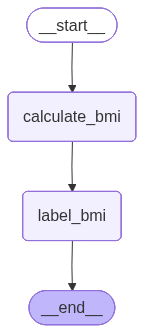

In [26]:
Image(workflow.get_graph().draw_mermaid_png())

### First Sequential Workflow - LLM based

- Simple QA workflow

In [27]:
class LLMState(TypedDict):
    question: str
    answer: str

In [28]:
# define graph

qa_graph = StateGraph(LLMState)

# define nodes - nodes are functions that take in a state and return a state
def llm_qa(state: LLMState) -> LLMState:

    question = state["question"]
    # build prompt 
    template = PromptTemplate(
        template="""
        You are a helpful assistant.
        Answer the following question: {question}
        """,
        input_variables=["question"]
    )

    prompt = template.format(question=question)
    answer = gpt_oss_20b_model.invoke(prompt).content
    
    state["answer"] = answer
    return state

qa_graph.add_node("llm_qa", llm_qa)
 
# add edges
qa_graph.add_edge(START, "llm_qa") # START and END are special dummy nodes
qa_graph.add_edge("llm_qa", END)

# compile graph
workflow = qa_graph.compile()

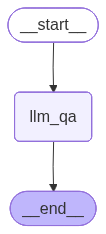

In [29]:
Image(workflow.get_graph().draw_mermaid_png())

In [30]:
initial_state = {"question": "What is the capital of India?"}
final_state = workflow.invoke(initial_state)
pprint(final_state)

{'answer': 'The capital of India is **New Delhi**.',
 'question': 'What is the capital of India?'}


### Prompt Chaining Workflow

In [33]:
class BlogState(TypedDict):
    title: str
    outline: str
    content: str

def create_outline(state: BlogState) -> BlogState:
    
    title = state["title"]
    # build prompt 
    template = PromptTemplate(
        template="""
        You are a helpful assistant.
        Create an outline for the following blog post: {title}
        """,
        input_variables=["title"]
    )
    prompt = template.format(title=title)
    outline = gpt_oss_20b_model.invoke(prompt).content
    state["outline"] = outline
    return state

def create_blog(state: BlogState) -> BlogState:
    
    title = state["title"]
    outline = state["outline"]
    # build prompt 
    template = PromptTemplate(
        template="""
        You are a helpful assistant.
        Create a short blog post for the following title: {title} and using the following outline:\n {outline}
        """,
        input_variables=["title", "outline"]
    )
    prompt = template.format(title=title, outline=outline)
    content = gpt_oss_20b_model.invoke(prompt).content
    state["content"] = content
    return state

# define graph
blog_graph = StateGraph(BlogState)

# define nodes - nodes are functions that take in a state and return a state
blog_graph.add_node("create_outline", create_outline)
blog_graph.add_node("create_blog", create_blog)

# add edges
blog_graph.add_edge(START, "create_outline")
blog_graph.add_edge("create_outline", "create_blog")
blog_graph.add_edge("create_blog", END)

# compile graph
workflow = blog_graph.compile()


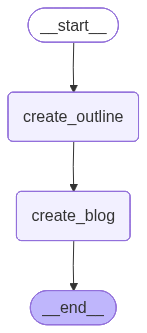

In [34]:
Image(workflow.get_graph().draw_mermaid_png())

In [36]:
initial_state = {"title": "LangGraph Tutorial"}
final_state = workflow.invoke(initial_state)

In [40]:
final_state.keys()

dict_keys(['title', 'outline', 'content'])

In [39]:
print(final_state["content"][:1000])

# LangGraph Tutorial  
*A quick‑start guide to building conversational AI workflows with LangGraph*

---

## 1. Introduction  

### What is LangGraph?  
LangGraph is a lightweight framework that lets you stitch together LLM calls, data‑transformations, and external APIs into a **graph‑based workflow**. Think of it as a visual, modular way to build chatbots, assistants, or any conversational system that needs to keep track of state, branch logic, and side‑effects.

Why it matters  
* **Modularity** – each node is a self‑contained unit.  
* **Scalability** – graphs can grow from a single LLM call to dozens of nodes.  
* **LLM agnostic** – plug in OpenAI, Anthropic, or any other provider with a single line.

### Target audience  
Developers, data scientists, and AI enthusiasts who want to prototype or deploy chatbots without wrestling with low‑level orchestration.

### What you’ll learn  
* Core concepts (nodes, edges, state, callbacks).  
* How to install and set up a project.  
* Buildi

### Simple Parallel Workflow

In [43]:
class BatsmanState(TypedDict):
    runs: int
    balls: int
    fours: int
    sixes: int
    strike_rate: float
    balls_per_boundary: float
    boundary_percentage: float
    summary: str
    
def calculate_strike_rate(state: BatsmanState) -> BatsmanState:
    state["strike_rate"] = state["runs"] / state["balls"] * 100
    return state

def calculate_balls_per_boundary(state: BatsmanState) -> BatsmanState:
    state["balls_per_boundary"] = state["balls"] / (state["fours"] + state["sixes"])
    return state

def calculate_boundary_percentage(state: BatsmanState) -> BatsmanState:
    state["boundary_percentage"] = ((state['fours']*4 + state['sixes']*6) / state['runs']) * 100
    return state

def summarize_performance(state: BatsmanState) -> BatsmanState:
    state["summary"] = f"The batsman has scored {state['runs']} runs in {state['balls']} balls \nwith a strike rate of {state['strike_rate']} and a boundary percentage of {state['boundary_percentage']}\n ball per boundary: {state['balls_per_boundary']}"
    return state


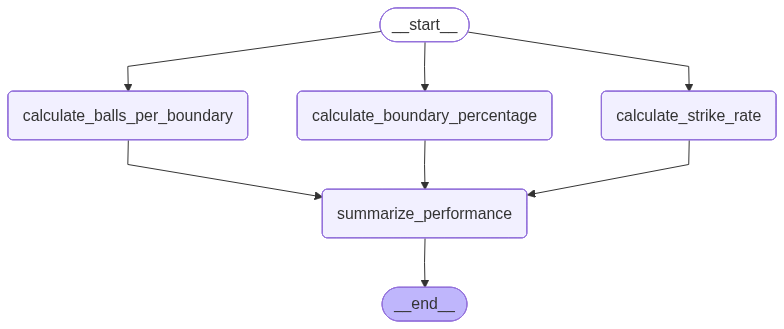

In [ ]:
batsman_graph = StateGraph(BatsmanState)

batsman_graph.add_node("calculate_strike_rate", calculate_strike_rate)
batsman_graph.add_node("calculate_balls_per_boundary", calculate_balls_per_boundary)
batsman_graph.add_node("calculate_boundary_percentage", calculate_boundary_percentage)
batsman_graph.add_node("summarize_performance", summarize_performance)

# add edges
batsman_graph.add_edge(START, "calculate_strike_rate")
batsman_graph.add_edge(START, "calculate_balls_per_boundary")
batsman_graph.add_edge(START, "calculate_boundary_percentage")

batsman_graph.add_edge("calculate_strike_rate", "summarize_performance")
batsman_graph.add_edge("calculate_balls_per_boundary", "summarize_performance")
batsman_graph.add_edge("calculate_boundary_percentage", "summarize_performance")
batsman_graph.add_edge("summarize_performance", END)

workflow = batsman_graph.compile()

Image(workflow.get_graph().draw_mermaid_png())

In [46]:
initial_state = {"runs": 100, "balls": 85, "fours": 10, "sixes": 3}
final_state = workflow.invoke(initial_state)
pprint(final_state)

InvalidUpdateError: At key 'runs': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE

Why this error?

The nodes to calculate sr, boundary_perc and bpb - all are returning the full state - however in parallel workflows this is a problem

This is because each step returns the full state as output

Since the state contains an attribute runs that is passed to all these steps in parallel - all of them might make concurrent updates to runs and return the full state

But the next state will not know which is the correct value of runs to use

This will cause an issue 

The solution is to use __partial updates to the state__

In [47]:
def calculate_strike_rate(state: BatsmanState) -> BatsmanState:
    strike_rate = state["runs"] / state["balls"] * 100
    return {"strike_rate": strike_rate} # NOTE: we only send the partial state as the next step and NOT the full state with the runs attribute

def calculate_balls_per_boundary(state: BatsmanState) -> BatsmanState:
    balls_per_boundary = state["balls"] / (state["fours"] + state["sixes"])
    return {"balls_per_boundary": balls_per_boundary} # NOTE: we only send the partial state as the next step and NOT the full state with the runs attribute

def calculate_boundary_percentage(state: BatsmanState) -> BatsmanState:
    boundary_percentage = ((state['fours']*4 + state['sixes']*6) / state['runs']) * 100
    return {"boundary_percentage": boundary_percentage} # NOTE: we only send the partial state as the next step and NOT the full state with the runs attribute

def summarize_performance(state: BatsmanState) -> BatsmanState:
    summary = f"The batsman has scored {state['runs']} runs in {state['balls']} balls \nwith a strike rate of {state['strike_rate']} and a boundary percentage of {state['boundary_percentage']}\n ball per boundary: {state['balls_per_boundary']}"
    return {"summary": summary} # NOTE: we only send the partial state as the next step and NOT the full state with the runs attribute

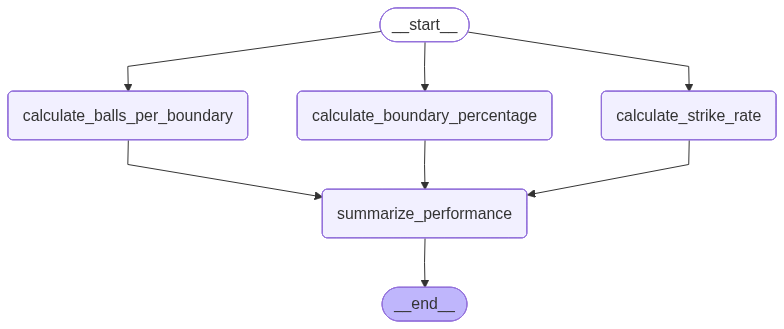

In [48]:
batsman_graph = StateGraph(BatsmanState)

batsman_graph.add_node("calculate_strike_rate", calculate_strike_rate)
batsman_graph.add_node("calculate_balls_per_boundary", calculate_balls_per_boundary)
batsman_graph.add_node("calculate_boundary_percentage", calculate_boundary_percentage)
batsman_graph.add_node("summarize_performance", summarize_performance)

# add edges
batsman_graph.add_edge(START, "calculate_strike_rate")
batsman_graph.add_edge(START, "calculate_balls_per_boundary")
batsman_graph.add_edge(START, "calculate_boundary_percentage")

batsman_graph.add_edge("calculate_strike_rate", "summarize_performance")
batsman_graph.add_edge("calculate_balls_per_boundary", "summarize_performance")
batsman_graph.add_edge("calculate_boundary_percentage", "summarize_performance")
batsman_graph.add_edge("summarize_performance", END)

workflow = batsman_graph.compile()

Image(workflow.get_graph().draw_mermaid_png())

In [49]:
initial_state = {"runs": 100, "balls": 85, "fours": 10, "sixes": 3}
final_state = workflow.invoke(initial_state)
pprint(final_state)

{'balls': 85,
 'balls_per_boundary': 6.538461538461538,
 'boundary_percentage': 57.99999999999999,
 'fours': 10,
 'runs': 100,
 'sixes': 3,
 'strike_rate': 117.64705882352942,
 'summary': 'The batsman has scored 100 runs in 85 balls \n'
            'with a strike rate of 117.64705882352942 and a boundary '
            'percentage of 57.99999999999999\n'
            ' ball per boundary: 6.538461538461538'}


### LLM Based Parallel Workflow

- UPSC evaluator workflow

Lets first build the model which follows the structured output component requirement

In [50]:
from pydantic import BaseModel, Field

In [52]:
essay = """India in the Age of AI
As the world enters a transformative era defined by artificial intelligence (AI), India stands at a critical juncture — one where it can either emerge as a global leader in AI innovation or risk falling behind in the technology race. The age of AI brings with it immense promise as well as unprecedented challenges, and how India navigates this landscape will shape its socio-economic and geopolitical future.

India's strengths in the AI domain are rooted in its vast pool of skilled engineers, a thriving IT industry, and a growing startup ecosystem. With over 5 million STEM graduates annually and a burgeoning base of AI researchers, India possesses the intellectual capital required to build cutting-edge AI systems. Institutions like IITs, IIITs, and IISc have begun fostering AI research, while private players such as TCS, Infosys, and Wipro are integrating AI into their global services. In 2020, the government launched the National AI Strategy (AI for All) with a focus on inclusive growth, aiming to leverage AI in healthcare, agriculture, education, and smart mobility.

One of the most promising applications of AI in India lies in agriculture, where predictive analytics can guide farmers on optimal sowing times, weather forecasts, and pest control. In healthcare, AI-powered diagnostics can help address India’s doctor-patient ratio crisis, particularly in rural areas. Educational platforms are increasingly using AI to personalize learning paths, while smart governance tools are helping improve public service delivery and fraud detection.

However, the path to AI-led growth is riddled with challenges. Chief among them is the digital divide. While metropolitan cities may embrace AI-driven solutions, rural India continues to struggle with basic internet access and digital literacy. The risk of job displacement due to automation also looms large, especially for low-skilled workers. Without effective skilling and re-skilling programs, AI could exacerbate existing socio-economic inequalities.

Another pressing concern is data privacy and ethics. As AI systems rely heavily on vast datasets, ensuring that personal data is used transparently and responsibly becomes vital. India is still shaping its data protection laws, and in the absence of a strong regulatory framework, AI systems may risk misuse or bias.

To harness AI responsibly, India must adopt a multi-stakeholder approach involving the government, academia, industry, and civil society. Policies should promote open datasets, encourage responsible innovation, and ensure ethical AI practices. There is also a need for international collaboration, particularly with countries leading in AI research, to gain strategic advantage and ensure interoperability in global systems.

India’s demographic dividend, when paired with responsible AI adoption, can unlock massive economic growth, improve governance, and uplift marginalized communities. But this vision will only materialize if AI is seen not merely as a tool for automation, but as an enabler of human-centered development.

In conclusion, India in the age of AI is a story in the making — one of opportunity, responsibility, and transformation. The decisions we make today will not just determine India’s AI trajectory, but also its future as an inclusive, equitable, and innovation-driven society."""

In [53]:
class EvaluationSchema(BaseModel):
    feedback: str = Field(description="Detailed feedback about the essay")
    score: int = Field(description="Score out of 100", ge=0, le=10)

structured_model = gpt_oss_20b_model.with_structured_output(EvaluationSchema)

In [54]:
template = PromptTemplate(
    template="""
    You are a UPSC evaluator.
    Evaluate the following essay and provide a score in the range of 0-10:
    {essay}
    """,
    input_variables=["essay"]
)

prompt = template.format(essay=essay)
response = structured_model.invoke(prompt)

In [57]:
response.score

8

In [58]:
print(response.feedback) 

The essay presents a clear and structured overview of India's position in the age of AI, highlighting strengths such as a large STEM talent pool, a growing startup ecosystem, and government initiatives like the National AI Strategy. It effectively identifies key application domains—agriculture, healthcare, education, and governance—illustrating how AI can address sectoral challenges. The discussion of challenges—digital divide, job displacement, data privacy, and ethical concerns—adds depth and demonstrates critical awareness. The concluding remarks tie the narrative back to inclusive, human‑centered development, reinforcing the essay’s thematic coherence.

Strengths:
1. **Logical structure**: Introduction, strengths, applications, challenges, solutions, conclusion.
2. **Use of data and examples**: Mentions 5 million STEM graduates, 2020 AI strategy, specific industry players.
3. **Balanced perspective**: Recognises both opportunities and risks.
4. **Policy recommendations**: Calls for

In [60]:
import operator

In [62]:
class UPSCState(TypedDict):
    essay: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback: str
    individual_scores: Annotated[list[int], operator.add] # NOTE: see the notes for explanation of this
    average_score: float



def evaluate_language(state: UPSCState) -> UPSCState:
    
    template = PromptTemplate(
    template="""
    You are a UPSC evaluator.
    Evaluate the following essay for language and provide a score in the range of 0-10:
    {essay}
    """,
    input_variables=["essay"]
)

    prompt = template.format(essay=state["essay"])
    response = structured_model.invoke(prompt)

    return {"language_feedback": response.feedback, "individual_scores": [response.score]}



def evaluate_analysis(state: UPSCState) -> UPSCState:
    template = PromptTemplate(
    template="""
    You are a UPSC evaluator.
    Evaluate the following essay for the level of analysis and provide a score in the range of 0-10:
    {essay}
    """,
    input_variables=["essay"]
)

    prompt = template.format(essay=state["essay"])
    response = structured_model.invoke(prompt)

    return {"analysis_feedback": response.feedback, "individual_scores": [response.score]}

def evaluate_clarity(state: UPSCState) -> UPSCState:
    template = PromptTemplate(
    template="""
    You are a UPSC evaluator.
    Evaluate the following essay for the clarity of the thought process and provide a score in the range of 0-10:
    {essay}
    """,
    input_variables=["essay"]
)

    prompt = template.format(essay=state["essay"])
    response = structured_model.invoke(prompt)

    return {"clarity_feedback": response.feedback, "individual_scores": [response.score]}

def evaluate_overall(state: UPSCState) -> UPSCState:
    summary_feedback_template = PromptTemplate(
    template="""
    Based on the following feedbacks, provide an overall summary feedback for the essay
    Language feedback: {language_feedback}
    Analysis feedback: {analysis_feedback}
    Clarity feedback: {clarity_feedback}
    """,
    input_variables=["language_feedback", "analysis_feedback", "clarity_feedback"]
)

    summary_feedback_prompt = summary_feedback_template.format(
        language_feedback=state["language_feedback"], 
        analysis_feedback=state["analysis_feedback"], 
        clarity_feedback=state["clarity_feedback"])
    response = gpt_oss_20b_model.invoke(summary_feedback_prompt)

    average_score = sum(state["individual_scores"]) / len(state["individual_scores"])

    return {"overall_feedback": response.content, "average_score": average_score}

In [64]:
upsc_graph = StateGraph(UPSCState)

upsc_graph.add_node("evaluate_language", evaluate_language)
upsc_graph.add_node("evaluate_analysis", evaluate_analysis)
upsc_graph.add_node("evaluate_clarity", evaluate_clarity)
upsc_graph.add_node("evaluate_overall", evaluate_overall)

In [65]:
# create edges
upsc_graph.add_edge(START, "evaluate_language")
upsc_graph.add_edge(START, "evaluate_analysis")
upsc_graph.add_edge(START, "evaluate_clarity")

upsc_graph.add_edge("evaluate_language", "evaluate_overall")
upsc_graph.add_edge("evaluate_analysis", "evaluate_overall")
upsc_graph.add_edge("evaluate_clarity", "evaluate_overall")
upsc_graph.add_edge("evaluate_overall", END)

workflow = upsc_graph.compile()

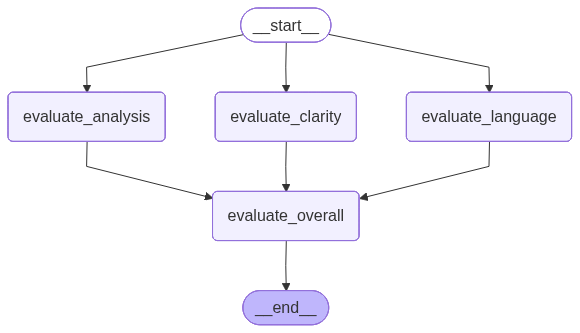

In [66]:
Image(workflow.get_graph().draw_mermaid_png())

In [70]:
workflow.invoke({"essay": essay[:100]})

{'essay': 'India in the Age of AI\nAs the world enters a transformative era defined by artificial intelligence (',
 'language_feedback': 'The essay is incomplete, ending abruptly after the opening sentence. The language used so far is clear and concise, with a formal tone appropriate for an academic piece. However, the lack of substantive content, development of ideas, and conclusion makes it impossible to assess depth, coherence, or argumentative strength. The structure is currently just a title and a fragment, so the overall quality is very limited. For a full evaluation, more content would be needed. Based on the available text, the essay scores very low on completeness and depth, but the language itself is correct and well‑written.',
 'analysis_feedback': 'The essay demonstrates a moderate level of analysis. It introduces the topic of AI in India and outlines potential benefits such as economic growth, healthcare improvements, and educational advancements. However, the discussion r